In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")


# Understanding the wandb properly

In [2]:
!pip install --upgrade wandb --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 75.2 MB/s eta 0:00:00:00:0100:01


In [3]:

import os
import wandb

In [7]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
WANDB_API_KEY = user_secrets.get_secret("wandb_api")


# Retrieve the API key from the Kaggle secrets
wandb.login(key=WANDB_API_KEY)

# Start a run, log some dummy 'loss' and a config
with wandb.init(project="kaggle-demo", config={"learning_rate": 0.01, "epochs": 5}) as run:
    for epoch in range(5):
        loss = 1 / (epoch + 1)  # Just simulated numbers
        wandb.log({"epoch": epoch, "loss": loss})


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gptc63926 (gptc63926-bennett-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


epoch,▁▃▅▆█
loss,█▄▂▁▁
epoch,4
loss,0.2


# direclty downloading the dataset from google drive 

In [4]:
!pip install gdown --quiet



In [5]:
# file link https://drive.google.com/open?id=1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM

import gdown
file_id="1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM"
url=url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url,"filename.zip",quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM
To: /kaggle/working/filename.zip
100%|██████████| 57.8k/57.8k [00:00<00:00, 47.8MB/s]


'filename.zip'

In [6]:
import zipfile

with zipfile.ZipFile("filename.zip", "r") as zip_ref:
    zip_ref.extractall("destination_folder")


In [19]:
import os
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import wandb
import matplotlib.pyplot as plt

In [8]:
df1=pd.read_json("/kaggle/working/destination_folder/dataset/training/data.json")
df1.head()

,input_polygon,colour,output_image
0,octagon.png,cyan,cyan_octagon.png
1,square.png,purple,purple_square.png
2,hexagon.png,magenta,magenta_hexagon.png
3,square.png,magenta,magenta_square.png
4,hexagon.png,purple,purple_hexagon.png


In [9]:
dataset_dir = '/kaggle/working/destination_folder/dataset/training'

inputs_dir = os.path.join(dataset_dir, 'inputs')
outputs_dir = os.path.join(dataset_dir, 'outputs')
json_path=os.path.join(dataset_dir,'data.json')

with open(json_path,'r') as f:
    data=json.load(f)

print(f"total samples: {len(data)}")
print("first sample: ",data[0])



total samples: 56
first sample:  {'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}


In [13]:
#to find the unique labels in the dataset of both input and output 
unique_shapes = set()
unique_colors = set()

for entry in data:
    # Extract shape name (strip extension from input_polygon)
    shape_name = os.path.splitext(entry['input_polygon'])[0]
    unique_shapes.add(shape_name)
    
    # Extract color
    unique_colors.add(entry['colour'])

# Print sorted lists
print("Unique polygon shapes:", sorted(unique_shapes))
print("Unique colors:", sorted(unique_colors))

Unique polygon shapes: ['circle', 'diamond', 'hexagon', 'octagon', 'pentagon', 'square', 'star', 'triangle']
Unique colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']


In [10]:
# Extract polygon name from filename
def get_polygon_name(filename):
    return os.path.splitext(filename)[0]

In [11]:
# Visualization function that displays polygon name and color
def visualize_sample(entry):
    input_path = os.path.join(inputs_dir, entry['input_polygon'])
    output_path = os.path.join(outputs_dir, entry['output_image'])
    color = entry['colour']
    polygon_name = get_polygon_name(entry['input_polygon'])

    input_img = Image.open(input_path)
    output_img = Image.open(output_path)

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"Polygon: {polygon_name} | Color: {color}", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.title('Input Polygon')
    plt.imshow(input_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Output Polygon')
    plt.imshow(output_img)
    plt.axis('off')

    plt.show()



Sample 1


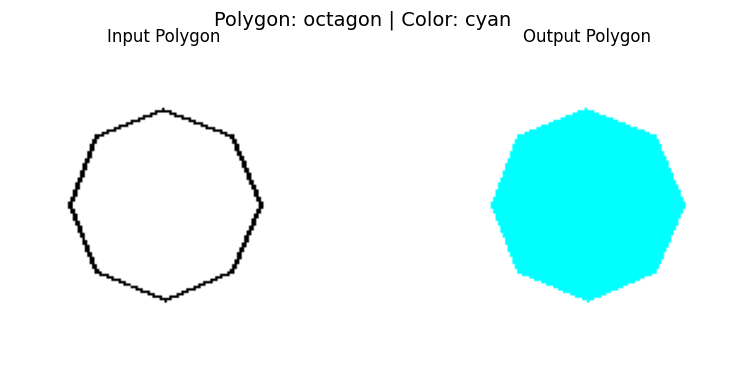


Sample 2


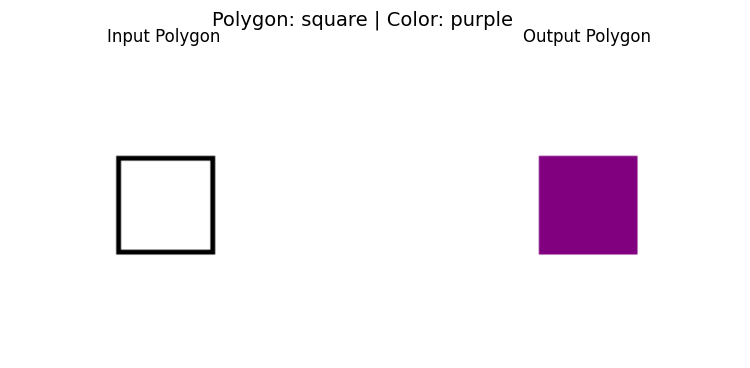


Sample 3


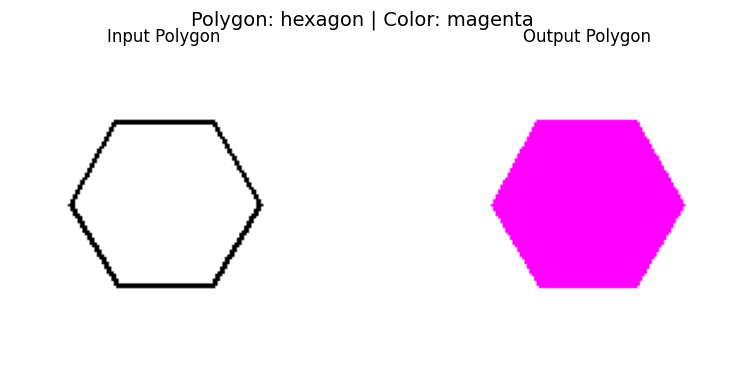

In [12]:
# Visualize the first 3 samples
for idx in range(3):
    print(f"\nSample {idx+1}")
    visualize_sample(data[idx])

In [20]:
train_dir = '/kaggle/working/destination_folder/dataset/training'
val_dir = '/kaggle/working/destination_folder/dataset/validation'

In [21]:
train_inputs_dir = os.path.join(train_dir, 'inputs')
train_outputs_dir = os.path.join(train_dir, 'outputs')
train_json = os.path.join(train_dir, 'data.json')

val_inputs_dir = os.path.join(val_dir, 'inputs')
val_outputs_dir = os.path.join(val_dir, 'outputs')
val_json = os.path.join(val_dir, 'data.json')

In [22]:
# Step 1: Extract Unique Colors (for one-hot encoding)
def get_unique_colors(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    unique_colors = set(entry['colour'] for entry in data)
    return sorted(unique_colors)

# Get unique colors from training data
ALL_COLORS = get_unique_colors(train_json)
COLOR_DIM = len(ALL_COLORS)
print(f"Unique colors: {ALL_COLORS}")
print(f"Color dimension for one-hot: {COLOR_DIM}")

Unique colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Color dimension for one-hot: 8


In [23]:
# Color to one-hot function
def color_to_onehot(color):
    idx = ALL_COLORS.index(color)
    vec = torch.zeros(COLOR_DIM)
    vec[idx] = 1.0
    return vec

In [24]:
# Image transforms (resize to 128x128 for simplicity; adjust as needed)
img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for stability
])

In [25]:
# PyTorch Dataset Class
class PolygonDataset(Dataset):
    def __init__(self, json_path, inputs_dir, outputs_dir, transform=None):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        self.inputs_dir = inputs_dir
        self.outputs_dir = outputs_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        input_path = os.path.join(self.inputs_dir, entry['input_polygon'])
        output_path = os.path.join(self.outputs_dir, entry['output_image'])
        color = entry['colour']

        input_img = Image.open(input_path).convert('RGB')
        output_img = Image.open(output_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        color_onehot = color_to_onehot(color)
        return input_img, color_onehot, output_img

In [26]:
# Create datasets and dataloaders
train_dataset = PolygonDataset(train_json, train_inputs_dir, train_outputs_dir, img_transform)
val_dataset = PolygonDataset(val_json, val_inputs_dir, val_outputs_dir, img_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [27]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, color_dim=COLOR_DIM):
        super().__init__()
        self.color_dim = color_dim

        # Encoder
        self.enc1 = DoubleConv(in_channels + color_dim, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up5 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec5 = DoubleConv(1024, 512)
        self.up6 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec6 = DoubleConv(512, 256)
        self.up7 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec7 = DoubleConv(256, 128)
        self.up8 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec8 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, 1)
        self.sigmoid = nn.Sigmoid()  # For output in [0,1]

    def forward(self, x, color_onehot):
        # Expand color_onehot to spatial dimensions
        color_expanded = color_onehot.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, color_expanded], dim=1)

        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with skip connections
        d5 = self.up5(b)
        d5 = torch.cat([d5, e4], dim=1)
        d5 = self.dec5(d5)
        d6 = self.up6(d5)
        d6 = torch.cat([d6, e3], dim=1)
        d6 = self.dec6(d6)
        d7 = self.up7(d6)
        d7 = torch.cat([d7, e2], dim=1)
        d7 = self.dec7(d7)
        d8 = self.up8(d7)
        d8 = torch.cat([d8, e1], dim=1)
        d8 = self.dec8(d8)

        out = self.final_conv(d8)
        return self.sigmoid(out)


In [30]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
WANDB_API_KEY = user_secrets.get_secret("wandb_api")

In [31]:
# Step 3: Training with wandb
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConditionalUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Suitable for image generation

# wandb setup (assuming you have set up secrets as before)
wandb.login(key=WANDB_API_KEY)  # Or use wandb.login()
wandb.init(project="ayna-unet-polygon", config={
    "learning_rate": 1e-3,
    "epochs": 50,
    "batch_size": 16
})

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gptc63926 (gptc63926-bennett-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [32]:
num_epochs = wandb.config.epochs
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, colors, targets in train_loader:
        inputs, colors, targets = inputs.to(device), colors.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, colors)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, colors, targets in val_loader:
            inputs, colors, targets = inputs.to(device), colors.to(device), targets.to(device)
            outputs = model(inputs, colors)
            val_loss += criterion(outputs, targets).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "epoch": epoch})
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")


Epoch 1/50 - Train Loss: 0.3983 - Val Loss: 0.3626
Epoch 2/50 - Train Loss: 0.3514 - Val Loss: 0.3431
Epoch 3/50 - Train Loss: 0.3218 - Val Loss: 0.3235
Epoch 4/50 - Train Loss: 0.2835 - Val Loss: 0.2704
Epoch 5/50 - Train Loss: 0.2616 - Val Loss: 0.2864
Epoch 6/50 - Train Loss: 0.2315 - Val Loss: 0.1973
Epoch 7/50 - Train Loss: 0.2120 - Val Loss: 0.2021
Epoch 8/50 - Train Loss: 0.1929 - Val Loss: 0.1936
Epoch 9/50 - Train Loss: 0.1762 - Val Loss: 0.1669
Epoch 10/50 - Train Loss: 0.1746 - Val Loss: 0.1452
Epoch 11/50 - Train Loss: 0.1587 - Val Loss: 0.1229
Epoch 12/50 - Train Loss: 0.1507 - Val Loss: 0.1248
Epoch 13/50 - Train Loss: 0.1420 - Val Loss: 0.1140
Epoch 14/50 - Train Loss: 0.1387 - Val Loss: 0.1157
Epoch 15/50 - Train Loss: 0.1348 - Val Loss: 0.1054
Epoch 16/50 - Train Loss: 0.1282 - Val Loss: 0.0978
Epoch 17/50 - Train Loss: 0.1242 - Val Loss: 0.0993
Epoch 18/50 - Train Loss: 0.1255 - Val Loss: 0.0917
Epoch 19/50 - Train Loss: 0.1202 - Val Loss: 0.0890
Epoch 20/50 - Train L

In [33]:
# Save model
torch.save(model.state_dict(), "unet_polygon_model.pth")
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,██▇▆▆▄▄▃▃▂▂▂▂▂▂▁▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_loss,0.11932
val_loss,0.0747


In [34]:
model = ConditionalUNet()
model.load_state_dict(torch.load("unet_polygon_model.pth"))
model.to(device)
model.eval()

ConditionalUNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True

In [35]:
# Example inference function
def infer(model, input_img_path, color_name):
    input_img = Image.open(input_img_path).convert('RGB')
    input_tensor = img_transform(input_img).unsqueeze(0).to(device)
    color_onehot = color_to_onehot(color_name).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor, color_onehot)
    output_img = transforms.ToPILImage()(output.squeeze(0).cpu())

    # Visualize
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Polygon")
    plt.imshow(input_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Generated Output ({color_name})")
    plt.imshow(output_img)
    plt.axis('off')
    plt.show()


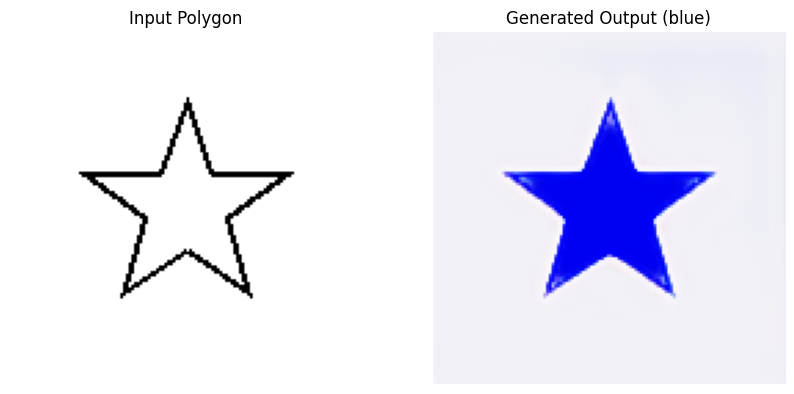

In [40]:
example_input = os.path.join(val_inputs_dir, 'star.png') 
example_color = 'blue'  
infer(model, example_input, example_color)

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
WANDB_API_KEY = user_secrets.get_secret("wandb_api")
api = wandb.Api()
run = api.run("/gptc63926-bennett-university/ayna-unet-polygon/runs/mfkunjfr")

print(run.history())

<IPython.core.display.Javascript object>